In [1]:
import yfinance as yf
import numpy as np

# Step 1: Data ingestion
ticker = "BTC-USD"
data = yf.download(ticker, start="2020-01-01", end="2026-01-01")

# Keep only Close and Volume
data = data[['Close', 'Volume']]

# Step 2: Feature engineering
close = data['Close']  # ensure Series

# Log returns
data['Returns'] = np.log(close / close.shift(1))

# Historical volatility
data['Volatility'] = data['Returns'].rolling(10).std()

# Mean and Z-score
mean_close = close.rolling(10).mean()
std20 = close.rolling(20).std()
data['Z_score'] = (close - mean_close) / std20

# Step 3: Data cleaning
data = data.dropna()




[*********************100%***********************]  1 of 1 completed


In [4]:
from sklearn.preprocessing import StandardScaler
# Step 4: Labeling
threshold=data['Volatility'].quantile(0.8)
data['Target']=np.where(data['Volatility']>threshold,-1,1)
# Step 5: Feature scaling 
features=['Returns','Volatility','Z_score']
X=data[features].values
y=data['Target'].values
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)
print(f"Data ready for optimization. Shape: {X_scaled.shape}")


Data ready for optimization. Shape: (2173, 3)


In [5]:
# STEP 6: Implementing a Soft-Margin (SVM)using Gradient Ascent on the Dual Lagrangian formulation.
import numpy as np
def compute_kernel_matrix(X,y):
    return (y[:,None]*y[None,:])*np.dot(X,X.T)

def train_svm(X,y,C,lr,epochs):
    n_samples = X.shape[0]
    alpha = np.zeros(n_samples) 
    K = compute_kernel_matrix(X, y)
    for epoch in range(epochs):
        gradient = np.ones(n_samples) - np.dot(K, alpha)
        alpha += lr * gradient
        alpha = np.clip(alpha, 0, C)
    w = np.dot(alpha * y, X)
    sv_idx = np.where((alpha > 1e-5) & (alpha < C))[0]
    b = np.mean(y[sv_idx] - np.dot(X[sv_idx], w)) if len(sv_idx) > 0 else 0
    return w,b,alpha
def  predict_risk(X, w, b):
    return np.sign(np.dot(X, w) + b)

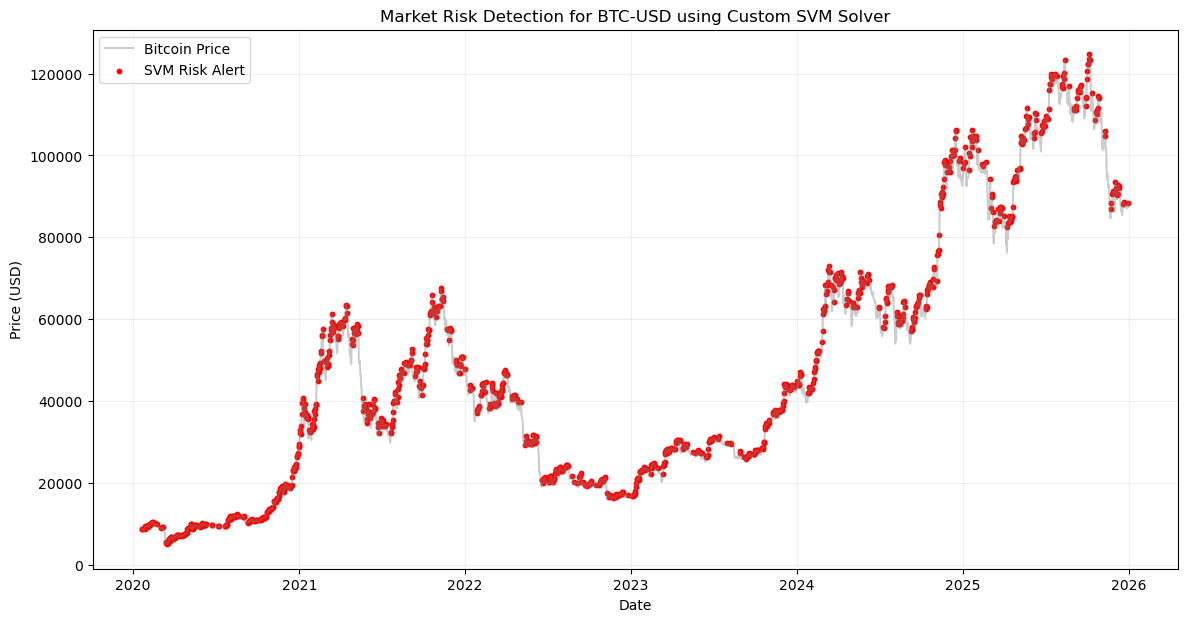

Number of Support Vectors found: 946


In [6]:
import matplotlib.pyplot as plt 
#  STEP 4: Taining and prediction
w, b, alphas = train_svm(X_scaled, y, C=1.0, lr=0.01, epochs=1000)
y_pred = predict_risk(X_scaled, w, b)
#  STEP 5:  Visualisation
data['Predicted_Risk'] = y_pred

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Bitcoin Price', color='gray', alpha=0.4)

# Plotting Risk Points detected by SVM
risky = data[data['Predicted_Risk'] == -1]
plt.scatter(risky.index, risky['Close'], color='red', s=10, label='SVM Risk Alert')

plt.title(f"Market Risk Detection for {ticker} using Custom SVM Solver")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

print(f"Number of Support Vectors found: {np.sum(alphas > 1e-5)}")